In [1]:
#%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import svd
import matplotlib as mpl
import time
import sys
from math import factorial
from scipy.ndimage.interpolation import shift

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

### Linestyles ###
colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['brown','green','blue','pink','black']
linewidth = [2,2,3,3,4]
linestyle = ['solid','dashed','dashdot','dotted','solid']

In [2]:
a = np.linspace(0,29,30).reshape(3,5,2)
print(a[1,2,0])
b=shift(a,[1,0,0],order=5,cval=0)
print(b[2,2,0])

14.0
13.999999999999995


In [3]:
a = np.linspace(0,29,30).reshape(3,5,2)
print(a[1,2,0])
b=np.roll(a,1,axis=2)
b[:,:,0]=0
print(b[1,2,1])
print(np.arange(0,5))

14.0
14.0
[0 1 2 3 4]


In [108]:
def c(state):
#        print("c",state[0,2,0], state.shape, len(state.shape))
    new_state = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if legs==3:
        new_state[:,0:-2,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,2:,:])
    elif legs==4:
        new_state[:,0:-2,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,2:,:,:])
    return new_state
def cd(state):
#        print("c",state[0,2,0], state.shape, len(state.shape))
    new_state = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if legs==3:
        new_state[:,2:,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,0:-2,:])
    elif legs==4:
        new_state[:,2:,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,0:-2,:,:])
    return new_state
def sm(state):
    new_state = np.zeros(state.shape,complex)
    if legs==3:
        new_state[:,0:dim_tS-1:2,:] = state[:,1:dim_tS:2,:]
    elif legs==4:
        new_state[:,0:dim_tS-1:2,:,:] = state[:,1:dim_tS:2,:,:]
    return new_state
def sp(state):
    new_state = np.zeros(state.shape,complex)
    if legs==3:
        new_state[:,1:dim_tS:2,:] = state[:,0:dim_tS-1:2,:]
    elif legs==4:
        new_state[:,1:dim_tS:2,:,:] = state[:,0:dim_tS-1:2,:,:]
    return new_state
def JC(state):
    new_tS_g = np.zeros(state.shape,complex)
    new_tS_Ome = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if len(state.shape)==3:
        new_tS_g[:,1:dim_tS-1:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:])
        new_tS_Ome[:,0:dim_tS-2:2,:] = Ome*state[:,1:dim_tS-1:2,:]
        new_tS_g[:,2:dim_tS:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:])
        new_tS_Ome[:,1:dim_tS-1:2,:] = Ome*state[:,0:dim_tS-2:2,:]
    elif len(state.shape)==4:
        new_tS_g[:,1:dim_tS-1:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:,:])
        new_tS_Ome[:,0:dim_tS-2:2,:,:] = Ome*state[:,1:dim_tS-1:2,:,:]
        new_tS_g[:,2:dim_tS:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:,:])
        new_tS_Ome[:,1:dim_tS-1:2,:,:] = Ome*state[:,0:dim_tS-2:2,:,:]
    return new_tS_g+new_tS_Ome
def nc(state):
    n=np.linspace(0,int((dim_tS)/2),dim_tS).astype(np.int64)
    print(n)
    new_state = np.zeros(state.shape,complex)
    if len(state.shape)==3:
        new_state = np.einsum("j,ijk->ijk",n,state)
    elif len(state.shape)==4:
        new_state = np.einsum("j,ijkl->ijkl",n,state)
    return new_state
def C(state):
    return Delc*nc(state)+Omc*(c(state)+cd(state))
def MS_or(state):
    new_tS = np.zeros(state.shape,complex)
    new_tS += state
    if legs==3:
        for i in range(dim_tS):
            if i%2==0:
                new_tS[:,i,:] = np.zeros((dim_tk,dim_tl),complex)
    elif legs==4:
        for i in range(dim_tS):
            if i%2==0:
                new_tS[:,i,:,:] = np.zeros((dim_tk,dim_tl,tl.shape[-1]),complex)
    return -1j*dt*(C(state)+JC(state)+Dele*new_tS)
Delc=0
Dele=0
g=2
Ome=0
Omc=0
dim_tS=initial.shape[1]
dim_tk=initial.shape[0]
dim_tl=initial.shape[2]
%time MS_or(initial)

[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.52 ms


array([[[0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0

In [109]:
def c(state):
#        print("c",state[0,2,0], state.shape, len(state.shape))
    new_state = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if legs==3:
        new_state[:,0:-2,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,2:,:])
    elif legs==4:
        new_state[:,0:-2,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,2:,:,:])
    return new_state
def cd(state):
#        print("c",state[0,2,0], state.shape, len(state.shape))
    new_state = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if legs==3:
        new_state[:,2:,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,0:-2,:])
    elif legs==4:
        new_state[:,2:,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,0:-2,:,:])
    return new_state
def sm(state):
    new_state = np.zeros(state.shape,complex)
    if legs==3:
        new_state[:,0:dim_tS-1:2,:] = state[:,1:dim_tS:2,:]
    elif legs==4:
        new_state[:,0:dim_tS-1:2,:,:] = state[:,1:dim_tS:2,:,:]
    return new_state
def sp(state):
    new_state = np.zeros(state.shape,complex)
    if legs==3:
        new_state[:,1:dim_tS:2,:] = state[:,0:dim_tS-1:2,:]
    elif legs==4:
        new_state[:,1:dim_tS:2,:,:] = state[:,0:dim_tS-1:2,:,:]
    return new_state
def JC(state):
    new_tS_g = np.zeros(state.shape,complex)
    new_tS_Ome = np.zeros(state.shape,complex)
    n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
    if len(state.shape)==3:
        new_tS_g[:,1:dim_tS-1:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:])
        new_tS_Ome[:,0:dim_tS-2:2,:] = Ome*state[:,1:dim_tS-1:2,:]
        new_tS_g[:,2:dim_tS:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:])
        new_tS_Ome[:,1:dim_tS-1:2,:] = Ome*state[:,0:dim_tS-2:2,:]
    elif len(state.shape)==4:
        new_tS_g[:,1:dim_tS-1:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:,:])
        new_tS_Ome[:,0:dim_tS-2:2,:,:] = Ome*state[:,1:dim_tS-1:2,:,:]
        new_tS_g[:,2:dim_tS:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:,:])
        new_tS_Ome[:,1:dim_tS-1:2,:,:] = Ome*state[:,0:dim_tS-2:2,:,:]
    return new_tS_g+new_tS_Ome
def nc(state):
    n=np.linspace(0,int((dim_tS)/2),dim_tS).astype(np.int64)
    print(n)
    new_state = np.zeros(state.shape,complex)
    if len(state.shape)==3:
        new_state = np.einsum("j,ijk->ijk",n,state)
    elif len(state.shape)==4:
        new_state = np.einsum("j,ijkl->ijkl",n,state)
    return new_state
def C(state):
    return Delc*nc(state)+Omc*(c(state)+cd(state))
def MS(state):
    new_tS = np.zeros(state.shape,complex)
    new_tS += state
    if legs==3:
        new_tS[:,0:dim_tS:2,:] = 0
    elif legs==4:
        new_tS[:,0:dim_tS:2,:,:] = 0
    return -1j*dt*(C(state)+JC(state)+Dele*new_tS)
%time MS(initial)

[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.44 ms


array([[[0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
         0.+0.j        ],
        [0

In [110]:
a = np.arange(0,5)
b = np.arange(0,15)
print(b[0:10:2])
initial = np.tensordot(a,np.tensordot(b,a,0),0)
gamma_L=1
gamma_R=1
phi=0
dt=0.005
#B_or(initial)==B(initial)
MS_or(initial)==MS(initial)

[0 2 4 6 8]
[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7]
[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7]


array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        

In [115]:
import numpy as np
import scipy as sc
from scipy.linalg import svd
import time
import sys
from decimal import Decimal
from math import factorial

############################
### Evolution operator U ###
############################
def U(tk,tS,tl,M,gamma_L,gamma_R,dt,phi,Ome,Omc,g,Delc,Dele): #tk: time bin state at k, tS: state of S
    """Evolution operator up to dt^2
    INPUT: states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable
    OUTPUT: combined block of states at t_k, for the system and at t_l"""
    
    #print(tk.shape,tS.shape,tl.shape,M)
    
    ####--------------------------####
    #### Parameters and operators ####
    ####--------------------------####
    
    #####Dimensions of the physical indices#####
    dim_tk = tk.shape[0]
    if len(tS.shape)==1:
        dim_tS = tS.shape[0]
        dim_tl = tl.shape[0]
    else:
        dim_tl = tl.shape[1]
        dim_tS = tS.shape[0]
#    print("dims",dim_tk,dim_tS,dim_tl)

    #####Frequently used operators#####
    def B(state):
        new_state_tk = np.zeros(state.shape,complex)
        new_state_tl = np.zeros(state.shape,complex)
        n = np.arange(1,state.shape[0])
        if legs==3:
            new_state_tk[0:-1,:,:] = np.einsum("i,ijk->ijk",np.sqrt(n*gamma_L*dt),state[1:,:,:])
            new_state_tl[:,:,0:-1] = np.einsum("k,ijk->ijk",np.sqrt(n*gamma_R*dt)*np.exp(-1j*phi),state[:,:,1:])
        elif legs==4:
            new_state_tk[0:-1,:,:,:] = np.einsum("i,ijkl->ijkl",np.sqrt(n*gamma_L*dt),state[1:,:,:,:])
            new_state_tl[:,:,0:-1,:] = np.einsum("k,ijkl->ijkl",np.sqrt(n*gamma_R*dt)*np.exp(-1j*phi),state[:,:,1:,:])
        return new_state_tk+new_state_tl
    def Bd(state):
        new_state_tk = np.zeros(state.shape,complex)
        new_state_tl = np.zeros(state.shape,complex)
        n = np.arange(1,state.shape[0])
        if legs==3:
            new_state_tk[1:,:,:] = np.einsum("i,ijk->ijk",np.sqrt(n*gamma_L*dt),state[0:-1,:,:])
            new_state_tl[:,:,1:] = np.einsum("k,ijk->ijk",np.sqrt(n*gamma_R*dt)*np.exp(-1j*phi),state[:,:,0:-1])
        elif legs==4:
            new_state_tk[1:,:,:,:] = np.einsum("i,ijkl->ijkl",np.sqrt(n*gamma_L*dt),state[0:-1,:,:,:])
            new_state_tl[:,:,1:,:] = np.einsum("k,ijkl->ijkl",np.sqrt(n*gamma_R*dt)*np.exp(-1j*phi),state[:,:,0:-1,:])
        return new_state_tk+new_state_tl
    def c(state):
    #        print("c",state[0,2,0], state.shape, len(state.shape))
        new_state = np.zeros(state.shape,complex)
        n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
        if legs==3:
            new_state[:,0:-2,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,2:,:])
        elif legs==4:
            new_state[:,0:-2,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,2:,:,:])
        return new_state
    def cd(state):
    #        print("c",state[0,2,0], state.shape, len(state.shape))
        new_state = np.zeros(state.shape,complex)
        n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
        if legs==3:
            new_state[:,2:,:] = np.einsum("j,ijk->ijk",np.sqrt(n),state[:,0:-2,:])
        elif legs==4:
            new_state[:,2:,:,:] = np.einsum("j,ijkl->ijkl",np.sqrt(n),state[:,0:-2,:,:])
        return new_state
    def sm(state):
        new_state = np.zeros(state.shape,complex)
        if legs==3:
            new_state[:,0:dim_tS-1:2,:] = state[:,1:dim_tS:2,:]
        elif legs==4:
            new_state[:,0:dim_tS-1:2,:,:] = state[:,1:dim_tS:2,:,:]
        return new_state
    def sp(state):
        new_state = np.zeros(state.shape,complex)
        if legs==3:
            new_state[:,1:dim_tS:2,:] = state[:,0:dim_tS-1:2,:]
        elif legs==4:
            new_state[:,1:dim_tS:2,:,:] = state[:,0:dim_tS-1:2,:,:]
        return new_state
    def JC(state):
        new_tS_g = np.zeros(state.shape,complex)
        new_tS_Ome = np.zeros(state.shape,complex)
        n=np.linspace(1,int((dim_tS)/2),dim_tS-2).astype(np.int64)
        if len(state.shape)==3:
            new_tS_g[:,1:dim_tS-1:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:])
            new_tS_Ome[:,0:dim_tS-2:2,:] = Ome*state[:,1:dim_tS-1:2,:]
            new_tS_g[:,2:dim_tS:2,:]   = np.einsum("j,ijk->ijk",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:])
            new_tS_Ome[:,1:dim_tS-1:2,:] = Ome*state[:,0:dim_tS-2:2,:]
        elif len(state.shape)==4:
            new_tS_g[:,1:dim_tS-1:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,2:dim_tS:2,:,:])
            new_tS_Ome[:,0:dim_tS-2:2,:,:] = Ome*state[:,1:dim_tS-1:2,:,:]
            new_tS_g[:,2:dim_tS:2,:,:]   = np.einsum("j,ijk->ijkl",np.sqrt(n[0:dim_tS-1:2])*g,state[:,1:dim_tS-1:2,:,:])
            new_tS_Ome[:,1:dim_tS-1:2,:,:] = Ome*state[:,0:dim_tS-2:2,:,:]
        return new_tS_g+new_tS_Ome
    def nc(state):
        n=np.linspace(0,int((dim_tS)/2),dim_tS).astype(np.int64)
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            new_state = np.einsum("j,ijk->ijk",n,state)
        elif len(state.shape)==4:
            new_state = np.einsum("j,ijkl->ijkl",n,state)
        return new_state
    def C(state):
        return Delc*nc(state)+Omc*(c(state)+cd(state))
    def MB(state):
        return Bd(c(state))-B(cd(state))
    def MS(state):
        new_tS = np.zeros(state.shape,complex)
        new_tS += state
        if legs==3:
            new_tS[:,0:dim_tS:2,:] = 0
        elif legs==4:
            new_tS[:,0:dim_tS:2,:,:] = 0
        return -1j*dt*(C(state)+JC(state)+Dele*new_tS)
    def Nn(tk,tS,tl,NBmin,NBmax):
        B_tk,B_tl = B(tk,tl)
        BdB_tk,BdB_tl = Bd(B_tk,B_tl)
        B_tk = None
        B_tl = None
        nc = np.linspace(0,(dim_tS-1)/2+.1,dim_tS).astype(np.int64)
        state = 0
        if legs==3:
            for i in range(NBmin,NBmax+1):
                state = np.tensordot(BdB_tk+(gamma_L+gamma_R)*dt*tk*i, np.tensordot((nc+1-i)*tS,BdB_tl,0),0)+state
        elif legs==4:
            for i in range(NBmin,NBmax+1):
                state = np.tensordot(BdB_tk+(gamma_L+gamma_R)*dt*tk*i, np.einsum("ij,jkl",(nc+1-i)*tS,BdB_tl))+state
        return state
        
    ####----------------------####
    #### Different terms in U ####
    ####----------------------####
    
    #####Initial state#####
    if len(tS.shape)==1:
        initial = np.tensordot(tk,np.tensordot(tS,tl,0),0)
    elif len(tS.shape)==2:
        if len(tl.shape)==3:
            initial = np.tensordot(tk,np.einsum("ij,jkl->ikl",tS,tl),0)
        elif len(tl.shape)==2:
            initial = np.tensordot(tk,np.einsum("ij,jk->ik",tS,tl),0)
    else:
        print("Unusual shape for tS")
#    print("init",initial[0,2,0],initial[1,0,0],initial[0,0,1],initial[0,0,0], initial.shape)
    legs = len(initial.shape)
	
    #####Environment#####
    MBi = np.zeros(initial.shape, complex)
    MBi += initial
    env = np.zeros(MBi.shape,complex)
#    print("env",env[0,0,0],env[1,0,0],env[0,0,1])
    for i in range(1,5):
        MBi = MB(MBi)/i
        env += MBi
#        print("env",env[0,0,0],env[1,0,0],env[0,0,1])
    MBi = None
    
    #####System#####
    sys = MS(initial+MS(initial)/2.)
    
    #####System-Environment#####
    sys_env = MS(MB(initial))
    sys_env += (.5*(MB(sys_env)) -
                0.5j*dt*( Bd(Delc*c(initial)+Omc*initial+g*sm(initial)) + 
                          B(Delc*cd(initial)+Omc*initial+g*sp(initial))-
                          (gamma_L+gamma_R)/3.*dt*(C(initial)+g*(c(sp(initial))+cd(sm(initial)))+
                                                   Delc*nc(initial)) + 2/3.*Delc*Bd(B(initial))))
#    print("sysenv",sys_env[0,2,0])

    return initial + sys + env + sys_env##



In [116]:
import numpy as np
import scipy as sc
from scipy.linalg import svd
import time
import sys
from decimal import Decimal
from math import factorial

############################
### Evolution operator U ###
############################
def U_or(tk,tS,tl,M,gamma_L,gamma_R,dt,phi,Ome,Omc,g,Delc,Dele): #tk: time bin state at k, tS: state of S
    """Evolution operator up to dt^2
    INPUT: states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable
    OUTPUT: combined block of states at t_k, for the system and at t_l"""
    
    #print(tk.shape,tS.shape,tl.shape,M)
    
    ####--------------------------####
    #### Parameters and operators ####
    ####--------------------------####
    
    #####Dimensions of the physical indices#####
    dim_tk = tk.shape[0]
    if len(tS.shape)==1:
        dim_tS = tS.shape[0]
        dim_tl = tl.shape[0]
    else:
        dim_tl = tl.shape[1]
        dim_tS = tS.shape[0]
#    print("dims",dim_tk,dim_tS,dim_tl)

    #####Frequently used operators#####
    def B(state):
        new_state_tk = np.zeros(state.shape,complex)
        new_state_tl = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tk-1):
                new_state_tk[i,:,:] = np.sqrt((i+1)*gamma_L*dt)*state[i+1,:,:]
                new_state_tl[:,:,i] = np.sqrt((i+1)*gamma_R*dt)*np.exp(-1j*phi)*state[:,:,i+1]
        elif len(state.shape)==4:
            for i in range(dim_tk-1):
                new_state_tk[i,:,:,:] = np.sqrt((i+1)*gamma_L*dt)*state[i+1,:,:,:]
                new_state_tl[:,:,i,:] = np.sqrt((i+1)*gamma_R*dt)*np.exp(-1j*phi)*state[:,:,i+1,:]
        else:
            print("Unusual shape for tS")
        return new_state_tk+new_state_tl
    def Bd(state):
        new_state_tk = np.zeros(state.shape,complex)
        new_state_tl = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tk-1):
                new_state_tk[i+1,:,:] = np.sqrt((i+1)*gamma_L*dt)*state[i,:,:]
                new_state_tl[:,:,i+1] = np.sqrt((i+1)*gamma_R*dt)*np.exp(1j*phi)*state[:,:,i]
        elif len(state.shape)==4:
            for i in range(dim_tk-1):
                new_state_tk[i+1,:,:,:] = np.sqrt((i+1)*gamma_L*dt)*state[i,:,:,:]
                new_state_tl[:,:,i+1,:] = np.sqrt((i+1)*gamma_R*dt)*np.exp(1j*phi)*state[:,:,i,:]
        else:
            print("Unusual shape for tS")
        return new_state_tk+new_state_tl
    def c(state):
#        print("c",state[0,2,0], state.shape, len(state.shape))
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS-2):
                new_state[:,i,:] = np.sqrt(int((i+2)/2))*state[:,i+2,:]
        elif len(state.shape)==4:
            for i in range(dim_tS-2):
                new_state[:,i,:,:] = np.sqrt(int((i+2)/2))*state[:,i+2,:,:]
        else:
            print("Unusual shape for tS")
#        print("c",new_state[0,0,0])
        return new_state
    def cd(state):
#        print("cd",state[0,2,0])
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS-2):
                new_state[:,i+2,:] = np.sqrt(int((i+2)/2))*state[:,i,:]
        elif len(state.shape)==4:
            for i in range(dim_tS-2):
                new_state[:,i+2,:,:] = np.sqrt(int((i+2)/2))*state[:,i,:,:]
        else:
            print("Unusual shape for tS")
#        print("cd",new_state[0,4,0])
        return new_state
    def sm(state):
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS-1):
                if i%2==0:
                    new_state[:,i,:] = state[:,i+1,:]
        elif len(state.shape)==4:
            for i in range(dim_tS-1):
                if i%2==0:
                    new_state[:,i,:,:] = state[:,i+1,:,:]
        else:
            print("Unusual shape for tS")
        return new_state
    def sp(state):
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS-1):
                if i%2==0:
                    new_state[:,i+1,:] = state[:,i,:]
        elif len(state.shape)==4:
            for i in range(dim_tS-1):
                if i%2==0:
                    new_state[:,i+1,:,:] = state[:,i,:,:]
        else:
            print("Unusual shape for tS")
        return new_state
    def JC(state):
        new_tS_g = np.zeros(state.shape,complex)
        new_tS_Ome = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS-2):
                if i%2==0:
                    new_tS_g[:,i+1,:]   = np.sqrt(np.int((i+2)/2))*g*state[:,i+2,:]
                    new_tS_Ome[:,i,:] = Ome*state[:,i+1,:]
    #                elif i%2==1:
                    new_tS_g[:,i+2,:]   = np.sqrt(np.int((i+2)/2))*g*state[:,i+1,:]
                    new_tS_Ome[:,i+1,:] = Ome*state[:,i,:]
        elif len(state.shape)==4:
            for i in range(dim_tS-2):
                if i%2==0:
                    new_tS_g[:,i+1,:,:]   = np.sqrt(np.int((i+2)/2))*g*state[:,i+2,:,:]
                    new_tS_Ome[:,i,:,:] = Ome*state[:,i+1,:,:]
    #                elif i%2==0:
                    new_tS_g[:,i+2,:,:]   = np.sqrt(np.int((i+2)/2))*g*state[:,i+1,:,:]
                    new_tS_Ome[:,i+1,:,:] = Ome*state[:,i,:,:]
        else:
            print("Unusual shape for tS")
        return new_tS_g+new_tS_Ome
    def nc(state):
        new_state = np.zeros(state.shape,complex)
        if len(state.shape)==3:
            for i in range(dim_tS):
                new_state[:,i,:] = np.int(i/2)*state[:,i,:]
        elif len(state.shape)==4:
            for i in range(dim_tS):
                new_state[:,i,:,:] = np.int(i/2)*state[:,i,:,:]
        else:
            print("Unusual shape for tS")
        return new_state
    def C(state):
        return Delc*nc(state)+Omc*(c(state)+cd(state))
    def MB(state):
        return Bd(c(state))-B(cd(state))
    def MS(state):
        new_tS = np.zeros(state.shape,complex)
        new_tS += state
        if len(state.shape)==3:
            for i in range(dim_tS):
                if i%2==0:
                    new_tS[:,i,:] = np.zeros((dim_tk,dim_tl),complex)
        elif len(state.shape)==4:
            for i in range(dim_tS):
                if i%2==0:
                    new_tS[:,i,:,:] = np.zeros((dim_tk,dim_tl,tl.shape[-1]),complex)
        else:
            print("Unusual shape for tS")
        return -1j*dt*(C(state)+JC(state)+Dele*new_tS)
    def Nn(tk,tS,tl,NBmin,NBmax):
        B_tk,B_tl = B(tk,tl)
        BdB_tk,BdB_tl = Bd(B_tk,B_tl)
        B_tk = None
        B_tl = None
        nc = np.linspace(0,(dim_tS-1)/2+.1,dim_tS).astype(np.int64)
        state = 0
        if len(state.shape)==3:
            for i in range(NBmin,NBmax+1):
                state = np.tensordot(BdB_tk+(gamma_L+gamma_R)*dt*tk*i, np.tensordot((nc+1-i)*tS,BdB_tl,0),0)+state
        elif len(state.shape)==4:
            for i in range(NBmin,NBmax+1):
                state = np.tensordot(BdB_tk+(gamma_L+gamma_R)*dt*tk*i, np.einsum("ij,jkl",(nc+1-i)*tS,BdB_tl))+state
        else:
            print("Unusual shape for tS")
        return state
        
    ####----------------------####
    #### Different terms in U ####
    ####----------------------####
    
    #####Initial state#####
    if len(tS.shape)==1:
        initial = np.tensordot(tk,np.tensordot(tS,tl,0),0)
    elif len(tS.shape)==2:
        if len(tl.shape)==3:
            initial = np.tensordot(tk,np.einsum("ij,jkl->ikl",tS,tl),0)
        elif len(tl.shape)==2:
            initial = np.tensordot(tk,np.einsum("ij,jk->ik",tS,tl),0)
    else:
        print("Unusual shape for tS")
#    print("init",initial[0,2,0],initial[1,0,0],initial[0,0,1],initial[0,0,0], initial.shape)
    
    #####Environment#####
    MBi = np.zeros(initial.shape, complex)
    MBi += initial
    env = np.zeros(MBi.shape,complex)
#    print("env",env[0,0,0],env[1,0,0],env[0,0,1])
    for i in range(1,5):
        MBi = MB(MBi)/i
        env += MBi
#        print("env",env[0,0,0],env[1,0,0],env[0,0,1])
    MBi = None
    
    #####System#####
    sys = MS(initial+MS(initial)/2.)
    
    #####System-Environment#####
    sys_env = MS(MB(initial))
    sys_env += (.5*(MB(sys_env)) -
                0.5j*dt*( Bd(Delc*c(initial)+Omc*initial+g*sm(initial)) + 
                          B(Delc*cd(initial)+Omc*initial+g*sp(initial))-
                          (gamma_L+gamma_R)/3.*dt*(C(initial)+g*(c(sp(initial))+cd(sm(initial)))+
                                                   Delc*nc(initial)) + 2/3.*Delc*Bd(B(initial))))
#    print("sysenv",sys_env[0,2,0])

    return initial + sys + env + sys_env##



In [117]:
%time U_or(a,b,a,2,.15,.05,0.005,0,0,0,2,0,0)
%time U(a,b,a,2,.15,.05,0.005,0,0,0,2,0,0)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.1 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.95 ms


array([[[ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.67705098e-05+0.00000000e+00j,
         -4.81841649e-05+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -3.06122429e-04+1.22474487e-05j,
         -7.74743385e-04+3.00000000e-05j,
         -1.37007218e-03+5.19615242e-05j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.83596911e-03+6.12372436e-06j,
         -4.58949453e-03+1.50000000e-05j,
         -8.05390450e-03+2.59807621e-05j],
        [ 0.00000000e+00+0.00000000e+00j,
         -2.73747170e-02+8.21583836e-04j,
         -5.74659775e-02+1.71244970e-03j,
         -8.88855017e-02+2.63445714e-03j,
         -1.21351600e-01+3.58027411e-03j],
        [ 0.00000000e+00+0.00000000e+00j,
         -7.73692973e-02+3.87298335e-04j,
         -1.60643296e-01+8.26558193e-04j,
         -2.46776862e-01+1.289

In [118]:
U_or(a,b,a,2,1,1,0.05,0,0,0,2,0,0)==U(a,b,a,2,1,1,0.05,0,0,0,2,0,0)

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        

In [ ]:
import numpy as np
import scipy as sc
from scipy.linalg import svd
import time
import sys
from decimal import Decimal
from math import factorial

#************************************#
#***------------------------------***#
#***| USEFUL BLOCKS AS FUNCTIONS |***#
#***------------------------------***#
#************************************#

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#################################################
### SVD with only significant singular values ###
#################################################
def SVD_sig(block,cutoff):
	"""Performing SVD with singular values above a certain threshold
	INPUT: the block to perform SVD on, threshold for singular values
	OUTPUT: SVD elements and the number of significant singular values"""

	# Predefining the list for the output
	svd_final = [0]*3

	# Performing the SVD
	svd_init  = svd(block,full_matrices=False)
	# Storing the singular values in an array
	sing      = np.array(svd_init[1])
	# Storing only the significant singular values
#	print(sing)

	d   = 0
	eps = 100.
	while eps>cutoff:
		d = d+1
		eps = np.sqrt(np.sum(sing[d:]**2))

	# Determining the number of significant singular values and resizing the svd matrices accordingly
	#print("link_dim",sing_num)
	if d==1:
		link_dim     = 0
		svd_final[0] = svd_init[0][:,0]
		svd_final[1] = sing[0]
		svd_final[2] = svd_init[2][0,:]
	else:
		link_dim = d
		svd_final[0] = svd_init[0][:,:link_dim]
		svd_final[1] = np.diag(sing[:d])
		svd_final[2] = svd_init[2][:link_dim,:]

	# Clear unnecessary variables
	svd_init  = None
	sing      = None
	sign_sing = None

	return svd_final,link_dim

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#######################
### Merging indices ###
#######################
def merge(block,where):
	"""Merging indices to provide a lower-rank tensor from a block
	INPUT: block for index-merging and the position of indices to be merged
	OUTPUT: block with the merged indices and the dimensions of the merged indices"""

	### Determining the rank of the tensor and the index-dimensions
	num_ind = len(block.shape)
	d1 = block.shape[0]
	d2 = block.shape[1]
    
	if num_ind == 2: # for a rank 2 tensor, there is no use of merging indices, return the original
		merged_block = block
		dims=None
        
	elif num_ind==3:
		d3 = block.shape[2]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1*d2,d3),dtype=np.complex128)
			for i in range(0,d1):
				for j in range(0,d2):
					merged_block[i+d1*j,:]=block[i,j,:]
			# passing on the merged dimensions
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1,d2*d3),dtype=np.complex128)
			for i in range(0,d2):
				for j in range(0,d3):
					merged_block[:,i+d2*j]=block[:,i,j]
			# passing on the merged dimensions
			dims = np.array([d2,d3])
	elif num_ind==4:
		d3 = block.shape[2]
		d4 = block.shape[3]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1*d2,d3,d4),dtype=np.complex128)
			for i in range(0,d1):
				for j in range(0,d2):
					merged_block[i+d1*j,:,:]=block[i,j,:,:]
			# passing on the merged dimensions
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
			for i in range(0,d3):
				for j in range(0,d4):
					merged_block[:,:,i+d3*j]=block[:,:,i,j]
			# passing on the merged dimensions
			dims = np.array([d3,d4])
		elif where=="both":
			# 2 consequent merges are needed           
			# predefinition of the first merged tensor
			merged_block_1 = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
			for i1 in range(0,d3):
				for j1 in range(0,d4):
					merged_block_1[:,:,i1+d3*j1]=block[:,:,i1,j1]
			# predefinition of the second merged tensor
			merged_block = np.zeros((d1*d2,d3*d4),dtype=np.complex128)
			for i2 in range(0,d1):
				for j2 in range(0,d2):
					merged_block[i2+d1*j2,:]=merged_block_1[i2,j2,:]
			merged_block_1=None
			# passing on the merged dimensions
			dims = np.array([d1,d2,d3,d4])
	return merged_block, dims

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

###################################
### Undo the merging of indices ###
###################################
def unmerge(block,dims,where):
	"""Unmerging indices to provide a higher-rank tensor from block
	INPUT: the block for which the index-merging should be undone, the dimensions of the final block indices
	and where the merged indices are
	OUTPUT: the obtained higher-rank tensor"""

	# predefinition of the unmerged tensor
	unmerged_block = np.zeros(dims,dtype=np.complex128)
	# In case no merge has been done, no unmerge is needed -> return the original
	if dims is None:
		unmerged_block = block
    
	elif where=="left":
		D = block.shape[0]
		d1 = dims[0]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				unmerged_block[I%d1,int((I-(I%d1))/d1)]  = block[I]
			elif len(block.shape)==2:
				unmerged_block[I%d1,int((I-(I%d1))/d1),:]  = block[I,:]
	elif where=="right":
		if len(block.shape)==1:
			D = block.shape[0]
		elif len(block.shape)==2:
			D = block.shape[1]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				d2 = dims[0]
				unmerged_block[I%d2,int((I-(I%d2))/d2)]  = block[I]
			elif len(block.shape)==2:
				d2 = dims[1]
				unmerged_block[:,I%d2,int((I-(I%d2))/d2)]  = block[:,I]
	block = None
	return unmerged_block

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

##########################################
### Relocating the orthognality centre ###
##########################################
def OC_reloc(state_left,state_right,where,tolerance):
	"""Relocating the orthogonality centre from either of the two adjacent timebins
	INPUT: time bin state on the left, on the right, where the orthogonality centre should go and the allowed
	tolerance of the SVD singular values
	OUTPUT: the obtained time bins on the left and right"""

	# Number of indices for each state besides the link index between them
	left_ind = len(state_left.shape)-1
	right_ind = len(state_right.shape)-1
	# Tensor after the contraction at the link index between the states
	Combo = np.tensordot(state_left,state_right,1)
	# Number of indices left after contraction
	num_ind = left_ind+right_ind

	if num_ind==2:
		Combo_svd,link_dim = SVD_sig(Combo,tolerance)
		if where=="left":
			new_left = np.dot(Combo_svd[0],Combo_svd[1])
			new_right = Combo_svd[2]
		elif where=="right":
			new_right = np.dot(Combo_svd[1],Combo_svd[2])
			new_left = Combo_svd[0]
		Combo_svd = None
        
	elif num_ind==3:
		if left_ind ==2: # link index is located on the left
			# Merging the indices on the left to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"left")
			# number of singular values that matter is in link_dim
			Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((merge_dims,np.array([link_dim])),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_left = unmerge(new_left_merged,dims,"left")
				new_left_merged=None
				new_right = Combo_merged_svd[2]
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_left = unmerge(Combo_merged_svd[0],dims,"left")
				Combo_merged_svd=None
		elif left_ind ==1: # link index is located on the right
			# Merging the indices on the right to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"right")
			# number of singular values that matter is in link_dim
			Combo_merged_svd, link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((np.array([link_dim]),merge_dims),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_right = unmerge(Combo_merged_svd[2],dims,"right")
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_right = unmerge(new_right_merged,dims,"right")
				new_right_merged=None
				new_left = Combo_merged_svd[0]            
				Combo_merged_svd=None
                
	elif num_ind==4:
		# Merging the indices on both sides to be able to perform svd
		Combo_merged,merge_dims = merge(Combo,"both")
		# number of singular values that matter is in link_dim
		Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
		Combo_merged=None
		# Dimensions of the indices on the left after the OC relocation and unmerge of indices
		dims_left = np.array([merge_dims[0],merge_dims[1],link_dim])
		# Dimensions of the indices on the right after the OC relocation and unmerge of indices
		dims_right = np.array([link_dim,merge_dims[2],merge_dims[3]])
		if where=="left":
			# OC relocation to the left
			new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
			# unmerging the indices on the left
			new_left = unmerge(new_left_merged,dims_left,"left")
			new_left_merged=None
			# unmerging the indices on the right
			new_right = unmerge(Combo_merged_svd[2],dims_right,"right")
		elif where=="right":
			# OC relocation to the right
			new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
			# unmerging the indices on the right
			new_right = unmerge(new_right_merged,dims_right,"right")
			new_right_merged=None
			# unmerging the indices on the left
			new_left = unmerge(Combo_merged_svd[0],dims_left,"left")
		Combo_merged_svd=None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

####################################
### Separate two physical blocks ###
####################################
def cut(block,tolerance,how,OC=None):
	"""cutting up a block to different time bins
	INPUT: block to be separated, the tolerance of the SVD singular values, where the link indices initially
	are and if on both sides, then which time bin should incorporate the orthogonality centre (optional)
	OUTPUT: the obtained time bins on the left and right"""

	# merging the link indices into the physical indices
	block_merged, dims = merge(block,how)
	# separate the block
	block_merged_svd,link_dim = SVD_sig(block_merged,tolerance)
	#print(block.shape, block_merged.shape)
	block_merged=None
	# specifying the link dimension
	if how=="left":
		# specifying the final indices of the left block
		if link_dim==0: # for separate bins
			left_dims = dims
		else:
			left_dims = np.concatenate((dims,np.array([link_dim])),axis=0)
		# unmerging the link index
		new_left = unmerge(block_merged_svd[0],left_dims,"left")
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right
			new_right = np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2])
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right
			new_right = block_merged_svd[1]*block_merged_svd[2]
		else:
			print("something's wrong with the ranks of the tensors after svd in cut left")
            
	elif how=="right":
		# specifying the final indices of the right block
		if link_dim==0: # for separate bins
			right_dims = dims
		else:
			right_dims = np.concatenate((np.array([link_dim]),dims),axis=0)
		new_left = block_merged_svd[0]
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(block_merged_svd[1]*block_merged_svd[2],right_dims,"right")
		else:
			print("something's wrong with the ranks of the tensors after svd in cut right")

	elif how=="both":
		if link_dim==0: # for separate bins
			left_dims = dims[:2]
			right_dims = dims[2:]
			new_right = unmerge(block_merged_svd[2],right_dims,"right")
			new_left = unmerge(block_merged_svd[0],left_dims,"left")
		# specifying the final indices of the blocks
		else: # for separate bins
			left_dims = np.concatenate((dims[:2],np.array([link_dim])),axis=0)
			right_dims = np.concatenate((np.array([link_dim]),dims[2:]),axis=0)
			if OC=="left":
				# positioning the orthognality centre to the left
				new_right = unmerge(block_merged_svd[2],right_dims,"right")
				new_left = unmerge(np.einsum("jk,kl->jl",block_merged_svd[0],block_merged_svd[1]),left_dims,"left")
			elif OC=="right":
				# positioning the orthognality centre to the right
				new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
				new_left = unmerge(block_merged_svd[0],left_dims,"left")
			elif OC== None:
				print("Please specify where is the orthogonality centre after operation with the keywords 'left' or 'right'")
	left_dims = None
	right_dims = None
	block_merged_svd = None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#########################
### Swapping timebins ###
#########################
def SWAP(states,base_ind,direction,OC,L,tol):
	"""Moving the interacting past bin over the length of the whole delay towards future or past bins.
	INPUT: list of timebins, index of start, direction of SWAPs ("future" or "past") and the location of
	the orthogonality centre (optional)
	OUTPUT: list of states that changed"""

	# Determining the direction of SWAPs
	if direction=="future":
		c = 1
	elif direction=="past":
		c=-1
        
	for s in range(0,L-1):
		# if the past bin is independent, tensor product should be performed
		if len(states[base_ind+c*s].shape)==1 :
			# if both bins are independent, swap does not need SVD, just a "shelf"
			if len(states[base_ind+c*s+1].shape)==1:
				right = states[base_ind+1+c*s]
				states[base_ind+c*s+1] = states[base_ind+c*s]
				states[base_ind+c*s] = right
				right=None
			# otherwise the cut function can be used to SWAP the bins
			elif len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.tensordot(states[base_ind+c*s+1],states[base_ind+c*s],0)
				# the physical indices should be swapped
				states[base_ind+c*s+1],states[base_ind+c*s] = cut(np.einsum("ijk->ikj",swap_block),tol,"left")
				# the cut function puts the OC to the right by default. In order to move the interacting past
				# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
				if direction =="future":
					if len(states[base_ind+c*s].shape)>1:
						states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],
                                                                               states[base_ind+c*s],"left",tol)
			else:
				print("problem with tensor rank in swap")
                
		elif len(states[base_ind+c*s].shape)==2 :            
			if len(states[base_ind+c*s+1].shape)==1:
				swap_block = np.tensordot(states[base_ind+1+c*s],states[base_ind+c*s],0)
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(np.einsum("ijk->jik",swap_block),tol,"right")     
			elif len(states[base_ind+c*s+1].shape)==3:
			# the physical indices should be swapped while contracting the link indices
				swap_block = np.einsum("ijk,kl->ilj",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"left")     
			# the cut function puts the OC to the right by default. In order to move the interacting past
			# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
				if direction =="future":
					states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],states[base_ind+c*s],
                                                                   "left",tol)
		else:            
			# the physical indices should be swapped while contracting the link indices
			if len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.einsum("ij,jlk->lik",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"right")     
			# the physical indices should be swapped while contracting the link indices
			else:
				swap_block = np.einsum("ijk,klm->iljm",states[base_ind+1+c*s],states[base_ind+c*s])
				if OC=="left":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","left")     
				elif OC=="right":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","right")     
	# because of the different directions of operations the position of the output states are either to the left
	# or to the right from the index of start
	if direction =="future":
		return states[base_ind:(base_ind+L)]
	elif direction =="past":
		return states[(base_ind-L+2):(base_ind+2)]

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

def coherent(n,phi,array):
    for i in range(len(array)):
        array[i] = np.exp(-n/2)*(np.sqrt(n)*np.exp(phi))**i/np.sqrt(float(factorial(i)))
    return array


#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#



In [ ]:
import numpy as np
import scipy as sc
from scipy.linalg import svd
import time
import sys
from decimal import Decimal
from math import factorial

#************************************#
#***------------------------------***#
#***| USEFUL BLOCKS AS FUNCTIONS |***#
#***------------------------------***#
#************************************#

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#################################################
### SVD with only significant singular values ###
#################################################
def SVD_sig(block,cutoff):
	"""Performing SVD with singular values above a certain threshold
	INPUT: the block to perform SVD on, threshold for singular values
	OUTPUT: SVD elements and the number of significant singular values"""

	# Predefining the list for the output
	svd_final = [0]*3

	# Performing the SVD
	svd_init  = svd(block,full_matrices=False)
	# Storing the singular values in an array
	sing      = np.array(svd_init[1])
	# Storing only the significant singular values
#	print(sing)

	d   = 0
	eps = 100.
	while eps>cutoff:
		d = d+1
		eps = np.sqrt(np.sum(sing[d:]**2))

	# Determining the number of significant singular values and resizing the svd matrices accordingly
	#print("link_dim",sing_num)
	if d==1:
		link_dim     = 0
		svd_final[0] = svd_init[0][:,0]
		svd_final[1] = sing[0]
		svd_final[2] = svd_init[2][0,:]
	else:
		link_dim = d
		svd_final[0] = svd_init[0][:,:link_dim]
		svd_final[1] = np.diag(sing[:d])
		svd_final[2] = svd_init[2][:link_dim,:]

	# Clear unnecessary variables
	svd_init  = None
	sing      = None
	sign_sing = None

	return svd_final,link_dim

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#######################
### Merging indices ###
#######################
def merge(block,where):
	"""Merging indices to provide a lower-rank tensor from a block
	INPUT: block for index-merging and the position of indices to be merged
	OUTPUT: block with the merged indices and the dimensions of the merged indices"""

	### Determining the rank of the tensor and the index-dimensions
	num_ind = len(block.shape)
	d1 = block.shape[0]
	d2 = block.shape[1]
    
	if num_ind == 2: # for a rank 2 tensor, there is no use of merging indices, return the original
		merged_block = block
		dims=None
        
	elif num_ind==3:
		d3 = block.shape[2]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = block.reshape(d1*d2,d3)
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = block.reshape(d1,d2*d3)
			# passing on the merged dimensions
			dims = np.array([d2,d3])
	elif num_ind==4:
		d3 = block.shape[2]
		d4 = block.shape[3]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = block.reshape(d1*d2,d3,d4)
			# passing on the merged dimensions
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = block.reshape(d1,d2,d3*d4)
			# passing on the merged dimensions
			dims = np.array([d3,d4])
		elif where=="both":
			# 2 consequent merges are needed           
			merged_block_1 = block.reshape(d1*d2,d3*d4)
			dims = np.array([d1,d2,d3,d4])
	return merged_block, dims

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

###################################
### Undo the merging of indices ###
###################################
def unmerge(block,dims,where):
	"""Unmerging indices to provide a higher-rank tensor from block
	INPUT: the block for which the index-merging should be undone, the dimensions of the final block indices
	and where the merged indices are
	OUTPUT: the obtained higher-rank tensor"""

	# predefinition of the unmerged tensor
	unmerged_block = np.zeros(dims,dtype=np.complex128)
	# In case no merge has been done, no unmerge is needed -> return the original
	if dims is None:
		unmerged_block = block
    
	elif where=="left":
		D = block.shape[0]
		d1 = dims[0]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				unmerged_block[I%d1,int((I-(I%d1))/d1)]  = block[I]
			elif len(block.shape)==2:
				unmerged_block[I%d1,int((I-(I%d1))/d1),:]  = block[I,:]
	elif where=="right":
		if len(block.shape)==1:
			D = block.shape[0]
		elif len(block.shape)==2:
			D = block.shape[1]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				d2 = dims[0]
				unmerged_block[I%d2,int((I-(I%d2))/d2)]  = block[I]
			elif len(block.shape)==2:
				d2 = dims[1]
				unmerged_block[:,I%d2,int((I-(I%d2))/d2)]  = block[:,I]
	block = None
	return unmerged_block

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

##########################################
### Relocating the orthognality centre ###
##########################################
def OC_reloc(state_left,state_right,where,tolerance):
	"""Relocating the orthogonality centre from either of the two adjacent timebins
	INPUT: time bin state on the left, on the right, where the orthogonality centre should go and the allowed
	tolerance of the SVD singular values
	OUTPUT: the obtained time bins on the left and right"""

	# Number of indices for each state besides the link index between them
	left_ind = len(state_left.shape)-1
	right_ind = len(state_right.shape)-1
	# Tensor after the contraction at the link index between the states
	Combo = np.tensordot(state_left,state_right,1)
	# Number of indices left after contraction
	num_ind = left_ind+right_ind

	if num_ind==2:
		Combo_svd,link_dim = SVD_sig(Combo,tolerance)
		if where=="left":
			new_left = np.dot(Combo_svd[0],Combo_svd[1])
			new_right = Combo_svd[2]
		elif where=="right":
			new_right = np.dot(Combo_svd[1],Combo_svd[2])
			new_left = Combo_svd[0]
		Combo_svd = None
        
	elif num_ind==3:
		if left_ind ==2: # link index is located on the left
			# Merging the indices on the left to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"left")
			# number of singular values that matter is in link_dim
			Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((merge_dims,np.array([link_dim])),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_left = unmerge(new_left_merged,dims,"left")
				new_left_merged=None
				new_right = Combo_merged_svd[2]
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_left = unmerge(Combo_merged_svd[0],dims,"left")
				Combo_merged_svd=None
		elif left_ind ==1: # link index is located on the right
			# Merging the indices on the right to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"right")
			# number of singular values that matter is in link_dim
			Combo_merged_svd, link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((np.array([link_dim]),merge_dims),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_right = unmerge(Combo_merged_svd[2],dims,"right")
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_right = unmerge(new_right_merged,dims,"right")
				new_right_merged=None
				new_left = Combo_merged_svd[0]            
				Combo_merged_svd=None
                
	elif num_ind==4:
		# Merging the indices on both sides to be able to perform svd
		Combo_merged,merge_dims = merge(Combo,"both")
		# number of singular values that matter is in link_dim
		Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
		Combo_merged=None
		# Dimensions of the indices on the left after the OC relocation and unmerge of indices
		dims_left = np.array([merge_dims[0],merge_dims[1],link_dim])
		# Dimensions of the indices on the right after the OC relocation and unmerge of indices
		dims_right = np.array([link_dim,merge_dims[2],merge_dims[3]])
		if where=="left":
			# OC relocation to the left
			new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
			# unmerging the indices on the left
			new_left = unmerge(new_left_merged,dims_left,"left")
			new_left_merged=None
			# unmerging the indices on the right
			new_right = unmerge(Combo_merged_svd[2],dims_right,"right")
		elif where=="right":
			# OC relocation to the right
			new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
			# unmerging the indices on the right
			new_right = unmerge(new_right_merged,dims_right,"right")
			new_right_merged=None
			# unmerging the indices on the left
			new_left = unmerge(Combo_merged_svd[0],dims_left,"left")
		Combo_merged_svd=None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

####################################
### Separate two physical blocks ###
####################################
def cut(block,tolerance,how,OC=None):
	"""cutting up a block to different time bins
	INPUT: block to be separated, the tolerance of the SVD singular values, where the link indices initially
	are and if on both sides, then which time bin should incorporate the orthogonality centre (optional)
	OUTPUT: the obtained time bins on the left and right"""

	# merging the link indices into the physical indices
	block_merged, dims = merge(block,how)
	# separate the block
	block_merged_svd,link_dim = SVD_sig(block_merged,tolerance)
	#print(block.shape, block_merged.shape)
	block_merged=None
	# specifying the link dimension
	if how=="left":
		# specifying the final indices of the left block
		if link_dim==0: # for separate bins
			left_dims = dims
		else:
			left_dims = np.concatenate((dims,np.array([link_dim])),axis=0)
		# unmerging the link index
		new_left = unmerge(block_merged_svd[0],left_dims,"left")
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right
			new_right = np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2])
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right
			new_right = block_merged_svd[1]*block_merged_svd[2]
		else:
			print("something's wrong with the ranks of the tensors after svd in cut left")
            
	elif how=="right":
		# specifying the final indices of the right block
		if link_dim==0: # for separate bins
			right_dims = dims
		else:
			right_dims = np.concatenate((np.array([link_dim]),dims),axis=0)
		new_left = block_merged_svd[0]
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(block_merged_svd[1]*block_merged_svd[2],right_dims,"right")
		else:
			print("something's wrong with the ranks of the tensors after svd in cut right")

	elif how=="both":
		if link_dim==0: # for separate bins
			left_dims = dims[:2]
			right_dims = dims[2:]
			new_right = unmerge(block_merged_svd[2],right_dims,"right")
			new_left = unmerge(block_merged_svd[0],left_dims,"left")
		# specifying the final indices of the blocks
		else: # for separate bins
			left_dims = np.concatenate((dims[:2],np.array([link_dim])),axis=0)
			right_dims = np.concatenate((np.array([link_dim]),dims[2:]),axis=0)
			if OC=="left":
				# positioning the orthognality centre to the left
				new_right = unmerge(block_merged_svd[2],right_dims,"right")
				new_left = unmerge(np.einsum("jk,kl->jl",block_merged_svd[0],block_merged_svd[1]),left_dims,"left")
			elif OC=="right":
				# positioning the orthognality centre to the right
				new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
				new_left = unmerge(block_merged_svd[0],left_dims,"left")
			elif OC== None:
				print("Please specify where is the orthogonality centre after operation with the keywords 'left' or 'right'")
	left_dims = None
	right_dims = None
	block_merged_svd = None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#########################
### Swapping timebins ###
#########################
def SWAP(states,base_ind,direction,OC,L,tol):
	"""Moving the interacting past bin over the length of the whole delay towards future or past bins.
	INPUT: list of timebins, index of start, direction of SWAPs ("future" or "past") and the location of
	the orthogonality centre (optional)
	OUTPUT: list of states that changed"""

	# Determining the direction of SWAPs
	if direction=="future":
		c = 1
	elif direction=="past":
		c=-1
        
	for s in range(0,L-1):
		# if the past bin is independent, tensor product should be performed
		if len(states[base_ind+c*s].shape)==1 :
			# if both bins are independent, swap does not need SVD, just a "shelf"
			if len(states[base_ind+c*s+1].shape)==1:
				right = states[base_ind+1+c*s]
				states[base_ind+c*s+1] = states[base_ind+c*s]
				states[base_ind+c*s] = right
				right=None
			# otherwise the cut function can be used to SWAP the bins
			elif len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.tensordot(states[base_ind+c*s+1],states[base_ind+c*s],0)
				# the physical indices should be swapped
				states[base_ind+c*s+1],states[base_ind+c*s] = cut(np.einsum("ijk->ikj",swap_block),tol,"left")
				# the cut function puts the OC to the right by default. In order to move the interacting past
				# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
				if direction =="future":
					if len(states[base_ind+c*s].shape)>1:
						states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],
                                                                               states[base_ind+c*s],"left",tol)
			else:
				print("problem with tensor rank in swap")
                
		elif len(states[base_ind+c*s].shape)==2 :            
			if len(states[base_ind+c*s+1].shape)==1:
				swap_block = np.tensordot(states[base_ind+1+c*s],states[base_ind+c*s],0)
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(np.einsum("ijk->jik",swap_block),tol,"right")     
			elif len(states[base_ind+c*s+1].shape)==3:
			# the physical indices should be swapped while contracting the link indices
				swap_block = np.einsum("ijk,kl->ilj",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"left")     
			# the cut function puts the OC to the right by default. In order to move the interacting past
			# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
				if direction =="future":
					states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],states[base_ind+c*s],
                                                                   "left",tol)
		else:            
			# the physical indices should be swapped while contracting the link indices
			if len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.einsum("ij,jlk->lik",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"right")     
			# the physical indices should be swapped while contracting the link indices
			else:
				swap_block = np.einsum("ijk,klm->iljm",states[base_ind+1+c*s],states[base_ind+c*s])
				if OC=="left":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","left")     
				elif OC=="right":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","right")     
	# because of the different directions of operations the position of the output states are either to the left
	# or to the right from the index of start
	if direction =="future":
		return states[base_ind:(base_ind+L)]
	elif direction =="past":
		return states[(base_ind-L+2):(base_ind+2)]

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

def coherent(n,phi,array):
    for i in range(len(array)):
        array[i] = np.exp(-n/2)*(np.sqrt(n)*np.exp(phi))**i/np.sqrt(float(factorial(i)))
    return array


#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#



In [125]:
block=np.arange(0,90).reshape(3,5,2,3)
d1=block.shape[0]
d2=block.shape[1]
d3=block.shape[2]
d4=block.shape[3]
b=block.reshape(d1*d2,d3*d4)
print(block,b)
c=b.reshape(d1,d2,d3,d4)
block==c


[[[[ 0  1  2]
   [ 3  4  5]]

  [[ 6  7  8]
   [ 9 10 11]]

  [[12 13 14]
   [15 16 17]]

  [[18 19 20]
   [21 22 23]]

  [[24 25 26]
   [27 28 29]]]


 [[[30 31 32]
   [33 34 35]]

  [[36 37 38]
   [39 40 41]]

  [[42 43 44]
   [45 46 47]]

  [[48 49 50]
   [51 52 53]]

  [[54 55 56]
   [57 58 59]]]


 [[[60 61 62]
   [63 64 65]]

  [[66 67 68]
   [69 70 71]]

  [[72 73 74]
   [75 76 77]]

  [[78 79 80]
   [81 82 83]]

  [[84 85 86]
   [87 88 89]]]] [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]
 [36 37 38 39 40 41]
 [42 43 44 45 46 47]
 [48 49 50 51 52 53]
 [54 55 56 57 58 59]
 [60 61 62 63 64 65]
 [66 67 68 69 70 71]
 [72 73 74 75 76 77]
 [78 79 80 81 82 83]
 [84 85 86 87 88 89]]


array([[[[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]]],


       [[[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]]],


       [[[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]]]])

In [131]:
def cut(block,tolerance,how,OC=None):
	"""cutting up a block to different time bins
	INPUT: block to be separated, the tolerance of the SVD singular values, where the link indices initially
	are and if on both sides, then which time bin should incorporate the orthogonality centre (optional)
	OUTPUT: the obtained time bins on the left and right"""

	# merging the link indices into the physical indices
	block_merged, dims = merge(block,how)
	# separate the block
	block_merged_svd,link_dim = SVD_sig(block_merged,tolerance)
	legs=len(block_merged_svd[2].shape)
	block_merged=None
	# specifying the link dimension
	if how=="left":
		# specifying the final indices of the left block
		if link_dim==0: # for separate bins
			left_dims = dims
		else:
			left_dims = np.concatenate((dims,np.array([link_dim])),axis=0)
		# unmerging the link index
		new_left = unmerge(block_merged_svd[0],left_dims,"left")
		if legs>1:
			# position the orthogonality centre to the right
			new_right = np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2])
		elif legs==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right
			new_right = block_merged_svd[1]*block_merged_svd[2]
		else:
			print("something's wrong with the ranks of the tensors after svd in cut left")
            
	elif how=="right":
		# specifying the final indices of the right block
		if link_dim==0: # for separate bins
			right_dims = dims
		else:
			right_dims = np.concatenate((np.array([link_dim]),dims),axis=0)
		new_left = block_merged_svd[0]
		if legs>1:
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
		elif legs==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(block_merged_svd[1]*block_merged_svd[2],right_dims,"right")
		else:
			print("something's wrong with the ranks of the tensors after svd in cut right")

	elif how=="both":
		if link_dim==0: # for separate bins
			left_dims = dims[:2]
			right_dims = dims[2:]
			new_right = unmerge(block_merged_svd[2],right_dims,"right")
			new_left = unmerge(block_merged_svd[0],left_dims,"left")
		# specifying the final indices of the blocks
		else: # for separate bins
			left_dims = np.concatenate((dims[:2],np.array([link_dim])),axis=0)
			right_dims = np.concatenate((np.array([link_dim]),dims[2:]),axis=0)
			if OC=="left":
				# positioning the orthognality centre to the left
				new_right = unmerge(block_merged_svd[2],right_dims,"right")
				new_left = unmerge(np.einsum("jk,kl->jl",block_merged_svd[0],block_merged_svd[1]),left_dims,"left")
			elif OC=="right":
				# positioning the orthognality centre to the right
				new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
				new_left = unmerge(block_merged_svd[0],left_dims,"left")
			elif OC== None:
				print("Please specify where is the orthogonality centre after operation with the keywords 'left' or 'right'")
	left_dims = None
	right_dims = None
	block_merged_svd = None
	return new_left,new_right

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'$N_B(t)$')

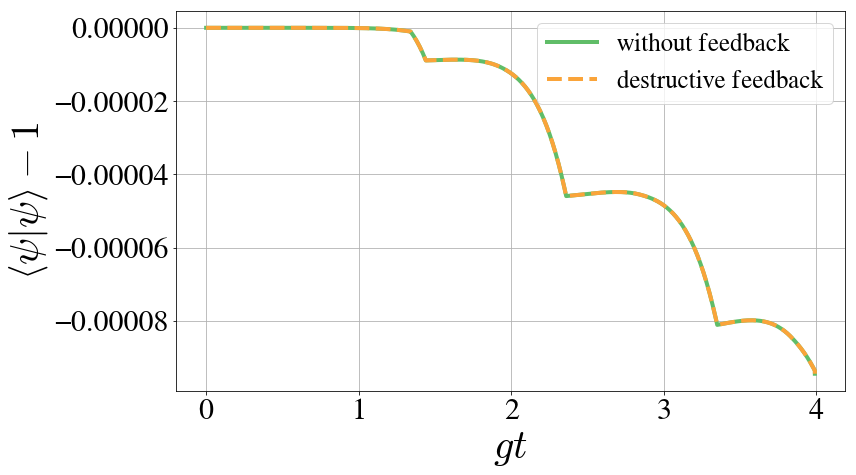

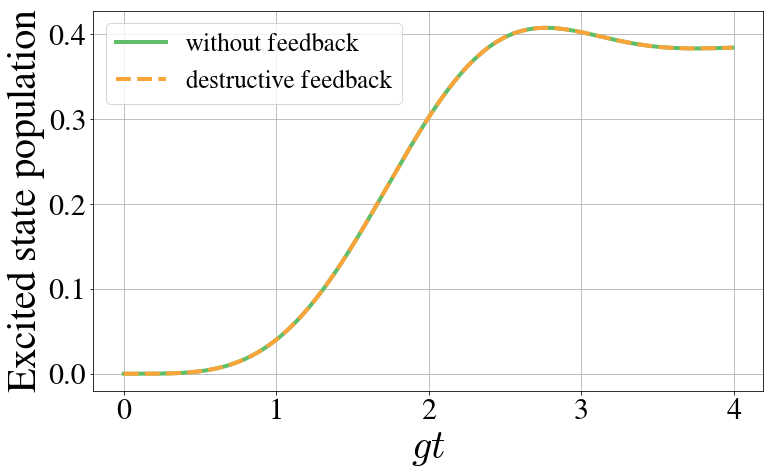

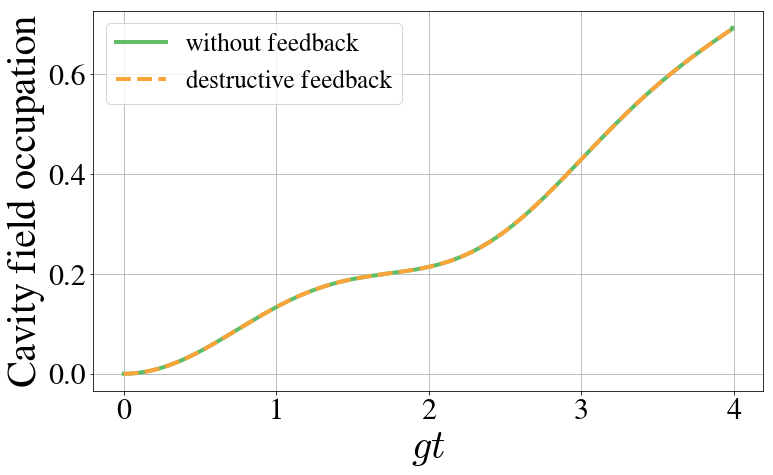

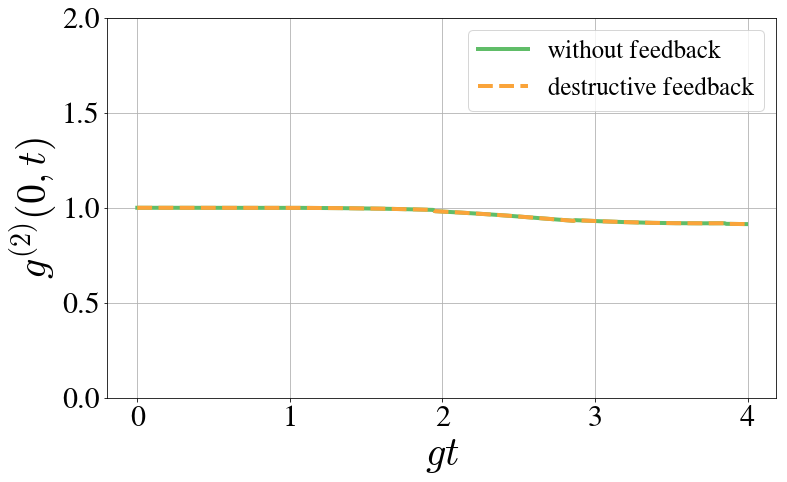

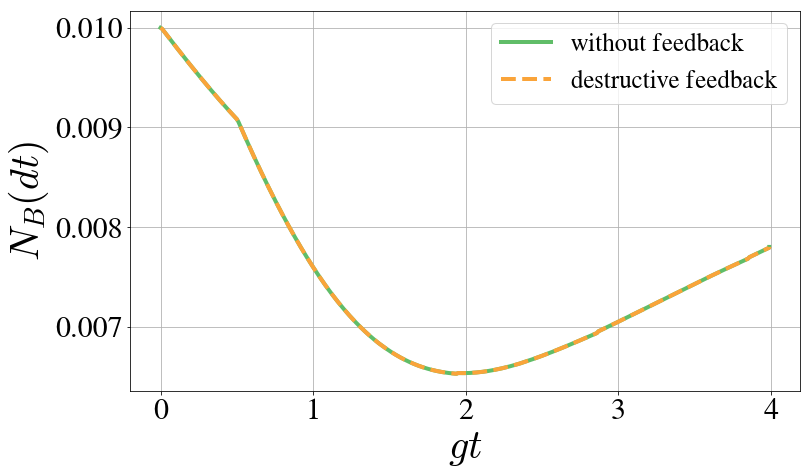

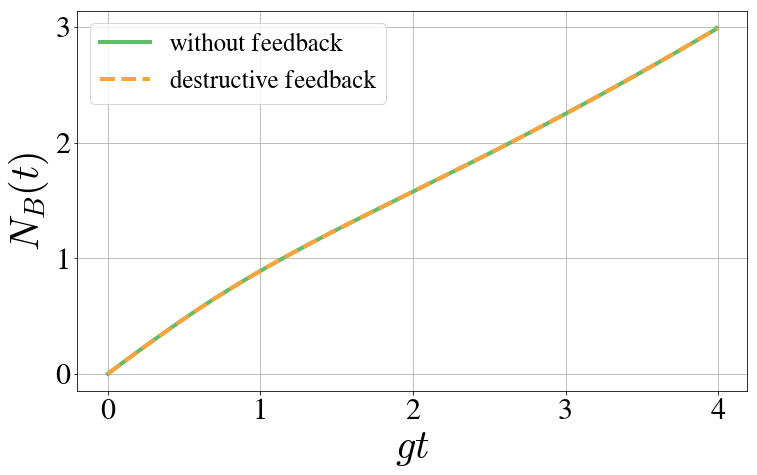

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from io import BytesIO

def conv(x):
    return x.replace('+-', '-').encode()

orig = np.genfromtxt((conv(x) for x in \
                      open("./Data/JC+fb_gL=1p10_gR=1p10_g=20p10_phi=0p10pi_cohe=1p100_initind=0_ome=0p10_omc=0p10_L=50_or.txt")),dtype=complex)
new = np.genfromtxt((conv(x) for x in \
                      open("./Data/JC+fb_gL=1p10_gR=1p10_g=20p10_phi=0p10pi_cohe=1p100_initind=0_ome=0p10_omc=0p10_L=50.txt")),dtype=complex)
t_or = orig[:,0]*2.
norm_or = orig[:,1]
exc_or = orig[:,2]
gr_or = orig[:,3]
cav_or = orig[:,4]
g2_or = orig[:,5]
NB_or = orig[:,6]
NBout_or = orig[:,7]
t_n = new[:,0]*2.
norm_n = new[:,1]
exc_n = new[:,2]
gr_n = new[:,3]
cav_n = new[:,4]
g2_n = new[:,5]
NB_n = new[:,6]
NBout_n = new[:,7]
plt.figure(figsize = (12,7))
plt.plot(t_or,norm_or-1,lw=4,label="without feedback",ls="-",color=colors["green"])
plt.plot(t_n,norm_n-1,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.grid(True)
plt.legend(loc="best",fontsize = 25)
#plt.xlim(0,10)
#plt.ylim(-0.5,0.5)
plt.ylabel("$\left<\psi|\psi\\right>-1$",fontsize=40)
plt.figure(figsize = (12,7))
plt.plot(t_or,exc_or,lw=4,label="without feedback",ls="-",color=colors["green"])
plt.plot(t_n,exc_n,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.grid(True)
plt.legend(loc="best",fontsize = 25)
plt.ylabel("Excited state population",fontsize=40)
#plt.ylim(-.1,1.1)
#plt.ylim(-0.1,1.1)
#plt.xlim(0,20)
plt.figure(figsize = (12,7))
plt.plot(t_or,cav_or,lw=4,label="without feedback",ls="-",color=colors["green"])
plt.plot(t_n,cav_n,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.grid(True)
plt.legend(loc="best",fontsize = 25)
plt.ylabel("Cavity field occupation",fontsize=40)
#plt.ylim(0,20)
#plt.xlim(0,20)
#plt.xlim(0,10)
plt.figure(figsize = (12,7))
plt.plot(t_or,g2_or,lw=4,label="without feedback",color=colors["green"])
plt.plot(t_n,g2_n,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.legend(loc="best",fontsize = 25)
plt.grid(True)
plt.ylabel("$g^{(2)}(0,t)$",fontsize=40)
plt.ylim(0,2)
plt.figure(figsize = (12,7))
plt.plot(t_or,NB_or/0.005,lw=4,label="without feedback",color=colors["green"])
plt.plot(t_n,NB_n/0.005,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.legend(loc="best",fontsize = 25)
plt.grid(True)
plt.ylabel("$N_B(dt)$",fontsize=40)
plt.figure(figsize = (12,7))
plt.plot(t_or,NBout_or/0.005,lw=4,label="without feedback",color=colors["green"])
plt.plot(t_n,NBout_n/0.005,lw=4,label="destructive feedback",ls="--",color=colors["orange"])
plt.xlabel("$gt$",fontsize=40)
plt.legend(loc="best",fontsize = 25)
plt.grid(True)
plt.ylabel("$N_B(t)$",fontsize=40)
